# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

#### I have read and understood the instructions:207404484_206483604

In [3]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [5]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

In [6]:
#### Your code here ####
x1_ones = X_training[np.where(y_training == 1)][:,0]
x2_ones = X_training[np.where(y_training == 1)][:,1]
x1_zeros = X_training[np.where(y_training == 0)][:,0]
x2_zeros = X_training[np.where(y_training == 0)][:,1]

x_training_first1000 = X_training[:1000]
y_training_first1000 = y_training[:1000]

x1_ones_first1000 = x_training_first1000[np.where(y_training_first1000 == 1)][:,0]
x2_ones_first1000 = x_training_first1000[np.where(y_training_first1000 == 1)][:,1]
x1_zeros_first1000 = x_training_first1000[np.where(y_training_first1000 == 0)][:,0]
x2_zeros_first1000 = x_training_first1000[np.where(y_training_first1000 == 0)][:,1]


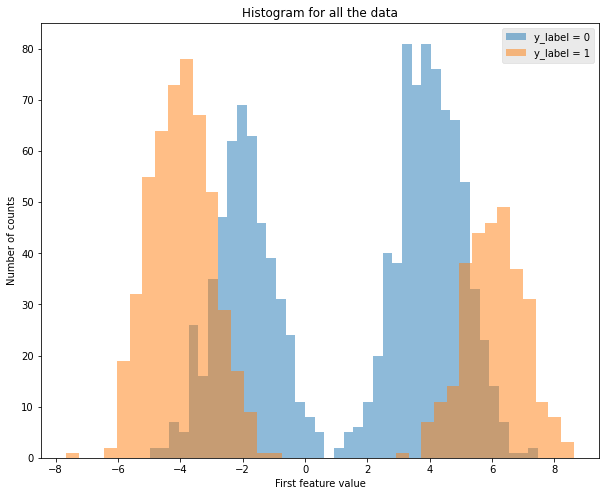

In [7]:
plt.title("Histogram for all the data")
plt.xlabel('First feature value')
plt.ylabel('Number of counts')
plt.style.use('ggplot')
plt.hist(x1_zeros, bins = 40, alpha = 0.5, label = 'y_label = 0')
plt.hist(x1_ones, bins = 40, alpha = 0.5, label = 'y_label = 1')
plt.legend()
plt.show()

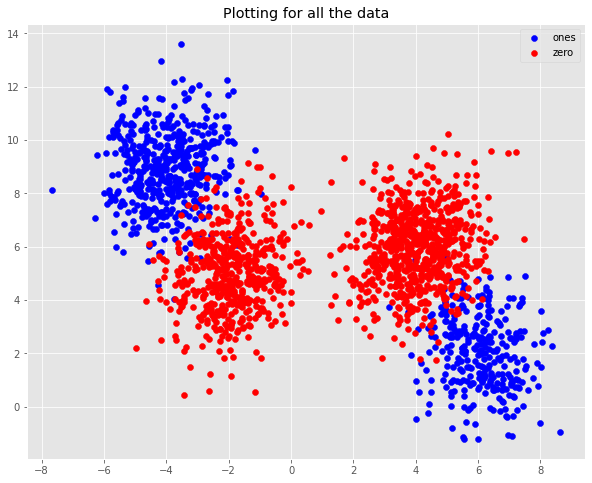

In [8]:
plt.title("Plotting for all the data")
plt.scatter(x1_ones, x2_ones, c = 'b', label = "ones")
plt.scatter(x1_zeros, x2_zeros, c = 'r', label = "zero")
plt.legend()
plt.show()

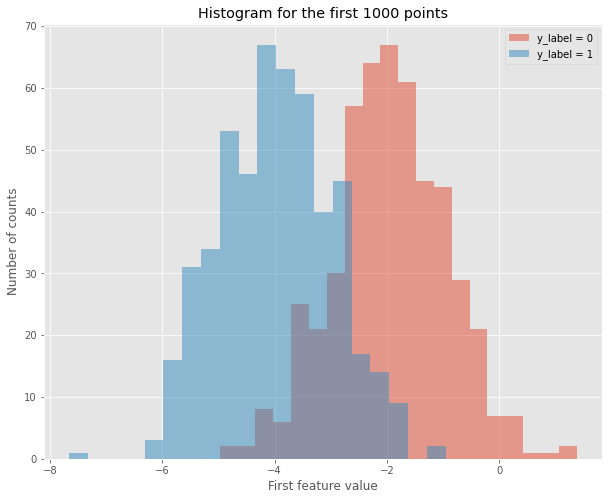

In [9]:
plt.title("Histogram for the first 1000 points")
plt.xlabel('First feature value')
plt.ylabel('Number of counts')
plt.style.use('ggplot')
plt.hist(x1_zeros_first1000, bins = 20, alpha = 0.5, label = 'y_label = 0')
plt.hist(x1_ones_first1000, bins = 20, alpha = 0.5, label = 'y_label = 1')
plt.legend()
plt.show()

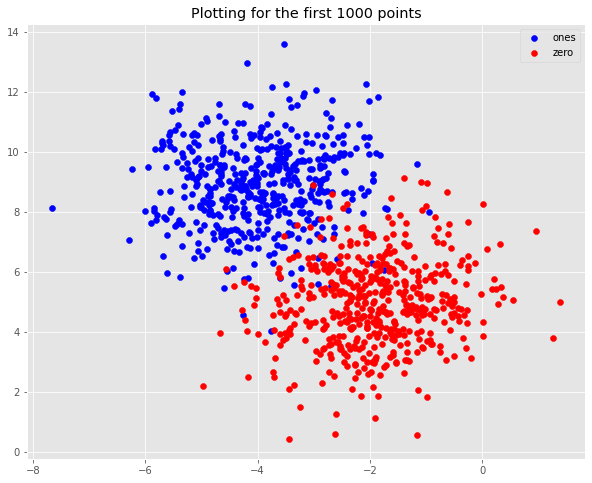

In [10]:
plt.title("Plotting for the first 1000 points")
plt.scatter(x1_ones_first1000, x2_ones_first1000, c = 'b', label = "ones")
plt.scatter(x1_zeros_first1000, x2_zeros_first1000, c = 'r', label = "zero")
plt.legend()
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [11]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = None
        self.J_history = None

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        X = self.bias_trick(X)
        J_history = [] # Use a python list to save cost in every iteration
        np.random.seed(self.random_state)
        theta = np.random.random(size= X.shape[1])  
        count = 1
        theta = theta - self.eta * (X.transpose() @ (self.sigmoid(X.dot(theta)) - y))   #calculating theta once outside the loop for indexing
        J_history.append(self.compute_cost(X, y, theta))   #appending the cost to J_history
        while (count < self.n_iter):   
            count += 1
            theta = theta - self.eta * (X.transpose() @ (self.sigmoid(X.dot(theta)) - y))   #update theta
            J_history.append(self.compute_cost(X, y, theta))   #appending the cost to J_history
            if J_history[-2] - J_history[-1] < eps:   #if the loss is smaller than eps than break out the loop 
                break
        self.theta = theta
        self.J_history = J_history
        
    
    def predict(self, X):
        """Return the predicted class label"""
        if X.shape[1] < len(self.theta):
            X = self.bias_trick(X)
        return self.sigmoid(X.dot(self.theta)).round()

    
    def compute_cost(self, X, y, theta):
        m,n = X.shape
        predictions = self.sigmoid(X.dot(theta))
        J = (-y).dot(np.log(predictions)) - (1 - y).dot(np.log(1 - predictions))
        return np.sum(J) / m

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def bias_trick(self, X):
        ones = [1 for i in range(0, X.shape[0])]   #creating a column of ones in the size of X_train
        X = np.column_stack([ones, X])       #adding the column to X_train
        return X


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [12]:
#a compute accuracy function that fits all classifiers
def compute_accuracy(classifier, X, y):
    acc = 0
    predictions = classifier.predict(X)
    for i in range(X.shape[0]):
        if predictions[i] == y[i]: acc+=1
    return acc/X.shape[0]

In [ ]:
accuracy_list = []
d = np.array(pd.read_csv('training_set.csv'))
np.random.seed(42)
np.random.shuffle(d)
training_sets = np.split(d, 5)
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

for eta in etas:
    for eps in epss:
        LRGD = LogisticRegressionGD(eta = eta, eps = eps)
        total_acc = 0
        for i in range(len(training_sets)):
            test_set = training_sets[i] # Each iteration, choose a different test set
            train_matrix = np.empty((0,3), float)
            
            # Build a complete dataset from the 4 chosen train sets
            for j in range(len(training_sets)):
                if(j == i): continue
                train_matrix = np.vstack((train_matrix, training_sets[j]))
            
            # Fit model and get accuracy
            LRGD.fit(X=train_matrix[:,:-1], y=train_matrix[:,-1])
            total_acc += compute_accuracy(LRGD, test_set[:,:-1], test_set[:,-1])

        accuracy_list.append((eta, eps, total_acc / 5))     

In [ ]:
max_list = (0,0,0)
for tple in accuracy_list:
    if tple[2] > max_list[2]:
        max_list = tple

best_eta, best_eps = max_list[0], max_list[1]
print(f"Best eta: {best_eta}, Best eps: {best_eps}")

## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [ ]:
# calc normal pdf    
def normal_pdf(data, mu, sigma):
    pi_part = (sigma * np.sqrt(2 * np.pi))
    e_part = np.exp(-0.5 * (((data - mu) / sigma) ** 2))
    return e_part / pi_part

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [ ]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=1):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.params = []
        self.w = []
        self.responsibilities = []
        self.J_history = []
        
    # initial guesses for parameters
    def init_params(self):
        """
        Initialize distribution params
        """
        np.random.seed(self.random_state)
        self.params = np.random.random(size=(self.k, 2))
        self.w = np.array([1 / self.k] * self.k)
        
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        resp = []
        for x in data:
            r_x = self.w * normal_pdf(x, self.params[:,0], self.params[:,1])
            resp.append(r_x/sum(r_x))
        self.responsibilities = np.array(resp)
        
    def maximization(self, data):
        """
        M step - updating distribution params
        """
        self.w = np.mean(self.responsibilities, axis=0) #update the w's
        
        for i in range(self.k):
            mu = np.sum(data.dot(self.responsibilities[:,i])) / (self.w[i] * data.shape[0]) #update the i'th mu
            sigma = np.sqrt(np.sum(((data - mu)**2).dot(self.responsibilities[:,i])/(self.w[i]*data.shape[0]))) #update the i'th sigma
            self.params[i][0] = mu
            self.params[i][1] = sigma
    
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params()
        self.J_history.append(self.compute_cost(data))
        for i in range(self.n_iter):
            self.expectation(data)
            self.maximizqweation(data)
            cost = self.compute_cost(data)
            if self.J_history[-1] - cost < self.eps: break
            self.J_history.append(cost)

    #returns an array of all parameters including the weights
    def get_dist_params(self):
        return np.hstack((self.params, self.w[:,None]))
    
    #computes the cost with the cost function
    def compute_cost(self, data):
        cost = 0
        for x in data:
            cost -= np.log(np.sum(self.w * normal_pdf(x, self.params[:,0], self.params[:,1])))
        return cost

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [ ]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.em = EM(k=k)
        self.data = None
        self.dist_params_0 = []
        self.dist_params_1 = []
        self.class_dataset_0 = []
        self.class_dataset_1 = []
        

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.data = X
        self.class_dataset_0 = self.data[(y==0),:]
        self.class_dataset_1 = self.data[(y==1),:]
        for feature in range(X.shape[1]):
            #save to the params list the dist params for class 0
            self.em.fit(self.class_dataset_0[:,feature]) 
            self.dist_params_0.append([param for param in self.em.get_dist_params()])
            #save to the params list the dist params for class 1
            self.em.fit(self.class_dataset_1[:,feature]) 
            self.dist_params_1.append([param for param in self.em.get_dist_params()])
        
        
    def predict(self, X):
        """Return the predicted class label"""
        predictions = []
        for x in X:
            if self.get_instance_posterior(x, 0) > self.get_instance_posterior(x, 1): predictions.append(0)
            else: predictions.append(1)
        return np.array(predictions)

    #get the prior probability
    def get_prior(self, label): 
        if label == 0: class_data = self.class_dataset_0
        else: class_data = self.class_dataset_1
        return len(class_data)/len(self.data)
    
    #get the likelihood according to normal pdf
    def get_instance_likelihood(self, x, label):
        params = []
        #check which parameters describe the distribution
        if label == 1: params = np.array(self.dist_params_1)
        else: params = self.dist_params_0
        product = 1
        for i in range(len(x)):
            product *= sum(w * normal_pdf(x[i], mu, sigma) for mu, sigma, w in params[i])
        return product
    
    #get the posterior probability
    def get_instance_posterior(self, x, label):
        return self.get_instance_likelihood(x, label)*self.get_prior(label)

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [ ]:
#divide the data to 1000(train) and 500(test)
X_new_train, y_new_train = X_training[:1000], y_training[:1000]
X_new_test, y_new_test = X_test[:500], y_test[:500]

In [ ]:
logistic_classifier = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_classifier.fit(X_new_train, y_new_train)
print("The Model Accuracy on the new training set is:", compute_accuracy(logistic_classifier, X_new_train, y_new_train))
print("The Model Accuracy on the new test set is    :", compute_accuracy(logistic_classifier, X_new_test, y_new_test))

In [ ]:
plt.plot(np.arange(len(logistic_classifier.J_history)), logistic_classifier.J_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations')
plt.show()
plt.title('Logistic regression classifier on first 1000 instances')
plot_decision_regions(X_new_train, y_new_train, logistic_classifier)
#in this graph we can see that the data is not linearly seperable, but the logistic regression gave us a good result of a seperator.
#the accuracy on the test is high, accuracy of 93.8%(relatively high)
#we can also see that until around the 2000th iteration the loss is relatively high and from then on it converges slowly

In [ ]:
NB_classifier = NaiveBayesGaussian(1)
NB_classifier.fit(X_new_train, y_new_train)
print("The Model Accuracy on the new training set is:", compute_accuracy(NB_classifier, X_new_train, y_new_train))
print("The Model Accuracy on the new test set is    :", compute_accuracy(NB_classifier, X_new_test, y_new_test))

In [ ]:
plt.title('naive bayes classifier on first 1000 instances')
plot_decision_regions(X_new_train, y_new_train, NB_classifier)
#here we can see that the naive bayes gave us a little better result,
#because the accuracy is higher, but it is very similar to the logistic

In [ ]:
logistic_classifier = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_classifier.fit(X_training, y_training)
print("The Model Accuracy on the new training set is:", compute_accuracy(logistic_classifier, X_training, y_training))
print("The Model Accuracy on the new test set is    :", compute_accuracy(logistic_classifier, X_test, y_test))
plt.title('Logistic regression classifier on all data')
plt.plot(np.arange(len(logistic_classifier.J_history)), logistic_classifier.J_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations')
plt.show()
#first we can see that the loss converges much faster than before, almost immediately

In [ ]:
plot_decision_regions(X_training, y_training, logistic_classifier)
#we can also see that the the linear seperator is seperating goodly the right part of the data, but it does not
#do a good job for the left side. we should notice that the data is not linearly seperable, and therefor we could not have
#expected a prefect seperation. that is why we got accuracy of around 80%

In [ ]:
NB_classifier = NaiveBayesGaussian(2)
NB_classifier.fit(X_training, y_training)
print("The Model Accuracy on the new training set is:", compute_accuracy(NB_classifier, X_training, y_training))
print("The Model Accuracy on the new test set is    :", compute_accuracy(NB_classifier, X_test, y_test))

In [ ]:
plt.title('naive bayes classifier on all data')
plot_decision_regions(X_training, y_training, NB_classifier, resolution = 0.01)
#we can see that this seperator is not linear. it suits this specific data better.

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


In [ ]:
from scipy.stats import multivariate_normal
import mpl_toolkits.mplot3d.axes3d as p3

label0 = np.zeros(500) # we make the labels correspoding for the instances we'll generate.
label1 = np.ones(500)

In [ ]:

#Logistic Better then the NAIVE
XLogistic0 = np.random.multivariate_normal([7, 7, 7],[[2, 11, 11],[11, 0, 11],[11, 11, 0]], size = 500) # we generate instances
XLogistic1 = np.random.multivariate_normal([-7, -7, -7],[[1, 11, 11],[11, 0, 11],[11, 11, 0]], size = 500) # that will be better accuracy for the logistic regression.

ForTheLogisticGraph = np.insert(np.append(XLogistic0, XLogistic1, axis = 0), 3, np.append(label0, label1, axis = 0), axis = 1)
np.random.shuffle(ForTheLogisticGraph)
X_dataset = ForTheLogisticGraph[:, :-1]
y_dataset = ForTheLogisticGraph [:, -1]

fig = plt.figure(figsize=(5,5)) # we plot everything on a 3-D module.
ax0 = p3.Axes3D(fig)

xx0 = XLogistic0[:, 0]
yy0 = XLogistic0[:, 1]
zz0 = XLogistic0[:, 2]
ax0.scatter(xx0, yy0, zz0, c ='k', marker='o')

xx1 = XLogistic1[:, 0]
yy1 = XLogistic1[:, 1]
zz1 = XLogistic1[:, 2]
ax0.scatter(xx1, yy1, zz1, c ='r', marker='o')
ax0.set_xlabel('feature 1')
ax0.set_ylabel('feature 2')
ax0.set_zlabel('feature 3')
plt.show()

In [ ]:
logistic_classifier0 = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_classifier0.fit(X_dataset,y_dataset)
print("The Model Accuracy For The Logistic Regression Is:", compute_accuracy(logistic_classifier0, X_dataset, y_dataset))
NB_classifier0 = NaiveBayesGaussian(1)
NB_classifier0.fit(X_dataset, y_dataset)
print("The Model Accuracy For The Naive Bayes Is:", compute_accuracy(NB_classifier0, X_dataset, y_dataset))

# as we can see the Logistic Regression Accuracy is better here. ( even though its very small different..) 

In [ ]:
##################################################
##            _   _   _    o          __        ##
##           ||\ ||  /_\  || \\  // ||__        ##
##           || \|| /   \ ||  \\//  ||__        ##
##################################################

#Naive is better here because we can't find a linear seperatable.
X_data0 = np.random.multivariate_normal([2, 1, 2],[[5, 0, 0],[0, 5, 0],[0, 0, 5]], size = 500) # we generate instances
X_data1 = np.random.rand(500, 3) # random points, so the NB will work better.

X_new_dataset = np.append(X_data0, X_data1, axis = 0)
y_new_dataset = np.append(label0, label1, axis = 0)
GraphPloting = np.insert(X_new_dataset, 3, y_new_dataset, axis = 1)
np.random.shuffle(GraphPloting)

X_dataset = GraphPloting[:, :-1]
y_dataset = GraphPloting [:, -1]

fig = plt.figure(figsize=(5,5)) # we plot everything on a 3-D module.
ax1 = p3.Axes3D(fig)

xx0 = X_data0[:, 0]
yy0 = X_data0[:, 1]
zz0 = X_data0[:, 2]
ax1.scatter(xx0, yy0, zz0, c ='k', marker='o')

xx1 = X_data1[:, 0]
yy1 = X_data1[:, 1]
zz1 = X_data1[:, 2]
ax1.set_xlabel('feature 1')
ax1.set_ylabel('feature 2')
ax1.set_zlabel('feature 3')
ax1.scatter(xx1, yy1, zz1, c ='b', marker='o')
plt.show()

In [ ]:
logistic_classifier0 = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_classifier0.fit(X_dataset,y_dataset)
print("The Model Accuracy For The Logistic Regression Is:", compute_accuracy(logistic_classifier0, X_dataset, y_dataset))
NB_classifier0 = NaiveBayesGaussian(1)
NB_classifier0.fit(X_dataset, y_dataset)
print("The Model Accuracy For The Naive Bayes Is:", compute_accuracy(NB_classifier0, X_dataset, y_dataset))

# here we can see that Naive works much better because our data is not linear seperatable.